In [5]:
import warnings
import random
import pickle

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb


warnings.simplefilter(action='ignore', category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


Notes: 
- for final presentation, maybe mention development date for algorithms 
- visualisierung für probierte werte 
- vergleichbare projekte von anderen + deren reached accuracy ( zum vergleich, um zu beweisen, dass unsere gut?)

# **0. Data Prep**

In [6]:
df = pd.read_csv('./data/brfss_imputed.csv')
pd.options.display.max_columns = None

# remove double indexing
df = df.drop(df.columns[0], axis=1)

# checking for nan's
print("No. of columns containing null values")
print(len(df.columns[df.isna().any()]))

print("No. of rows containing null values")
print(df.isnull().any(axis=1).sum())

# dropping unsused columns
df = df[df.columns.drop(list(df.filter(regex='unk_')))]
df = df[df.columns.drop(list(df.filter(regex='not_known_')))]
df = df[df.columns.drop(list(df.filter(regex='_was_missing')))]
df = df.drop(df.columns[0], axis=1)


# splitting into target & features df
target = df['DIABETE4']
features = df.drop(['DIABETE4'], axis=1)

# splitting into training and test data
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=42)

# print(features_train.shape)
# print(features_test.shape)
# print(target_train.shape)
# print(target_test.shape)

(377880, 147)

# **3. XG - Boosting**

## **3.1 Optimizing n_estimators**

In [18]:
# Optimizing n_estimators to reach the highest possible accuracy

# N_ESTIMATORS should be max the SEARCHSPACE so all possibilities are tried once
MAX_EVALS = 100
SEARCH_SPACE = [hp.uniformint('n_estimators', 300, 30000)]

### Optimizaion ##############################################################################################################


def cost_function(n_estimators):
    n_estimators = n_estimators[0]
    if n_estimators == 0:
        return 0
    xgb_classifier = xgb.XGBClassifier(n_estimators=n_estimators, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3).fit(features_train, target_train)
    sgb_predictions = xgb_classifier.predict(features_test)
    sgb_accuracy = accuracy_score(target_test, sgb_predictions)
    return {'loss': - sgb_accuracy, 'status': STATUS_OK}


trials = Trials()
best = fmin(cost_function,
            space=SEARCH_SPACE,
            algo=tpe.suggest,
            max_evals=MAX_EVALS,
            trials=trials)

print(best)


100%|██████████| 100/100 [9:42:15<00:00, 349.35s/trial, best loss: -0.871387742140362]   
{'n_estimators': 2265.0}


best loss:  -0.871387742140362

{'n_estimators': 2265.0}

## **3.2 Training & saving model with optimized n_estimators**

In [19]:
n_estimators = int(best['n_estimators'])

xgb_classifier = xgb.XGBClassifier(n_estimators=n_estimators, objective='binary:logistic', tree_method='hist', eta=0.1, max_depth=3).fit(features_train, target_train)
sgb_predictions = xgb_classifier.predict(features_test)
sgb_accuracy = accuracy_score(target_test, sgb_predictions)


filename = 'xgb_model.pickle'

pickle.dump(xgb_classifier, open(filename, "wb"))


In [20]:
filename = 'model_final.pickle'

pickle.dump(xgb_classifier, open(filename, "wb"))


## **3.3 Importing model to predict for one person**

In [31]:
# Usage Example' #################################################################################################

xgb_classifier = pickle.load(open('model_final.pickle', "rb"))


# This would be the answers given by the user 
# (here i am getting a random row from the dataset for demonstration)
example_input = features_test.iloc[576] 
# print(example_input)


def make_prediction (xgb_classifier, input):
    prediction = xgb_classifier.predict(input)

    return prediction


prediction = make_prediction(xgb_classifier, example_input)
print(prediction)


ValueError: training data did not have the following fields: GENHLTH, PHYSHLTH, MENTHLTH, POORHLTH, PERSDOC3, MEDCOST1, CHECKUP1, EXERANY2, BPMEDS, TOLDHI3, CHOLMED3, CVDINFR4, CVDCRHD4, CVDSTRK3, ASTHMA3, ASTHNOW, CHCSCNCR, CHCOCNCR, CHCCOPD3, ADDEPEV3, CHCKDNY2, HAVARTH5, VETERAN3, PREGNANT, DEAF, BLIND, DECIDE, DIFFWALK, DIFFDRES, DIFFALON, SMOKE100, ALCDAY5, AVEDRNK3, DRNK3GE5, MAXDRNKS, FLUSHOT7, PNEUVAC4, HIVTST7, _METSTAT, _URBSTAT, _HLTHPLN, _AGE80, HTIN4, WTKG3, _INCOMG1, FTJUDA2_, FRUTDA2_, GRENDA1_, FRNCHDA_, POTADA1_, VEGEDA2_, high_blood_pressure, pregnant_high_blood_pressure, borderline_high_blood_pressure, cholesterol_checked_within_year, married, divorced, widowed, separated, never_married, unmarried_couple, own_house, renting, other_arrangement_housing, employed_for_wages, self_employed, out_of_work_year_plus, out_of_work_year_less, homemaker, student, retired, unable_to_work, smoke_every_day, smoke_some_days, smoke_not_at_all, smokeless_every_day, smokeless_some_days, smokeless_not_at_all, ecig_every_day, ecig_some_days, ecig_not_at_all, ecig_never_used, white, black, asian, native, hispanic, not_graduate_high_school, graduated_high_school, attended_college, graduated_college

# **4. Vizualisations**

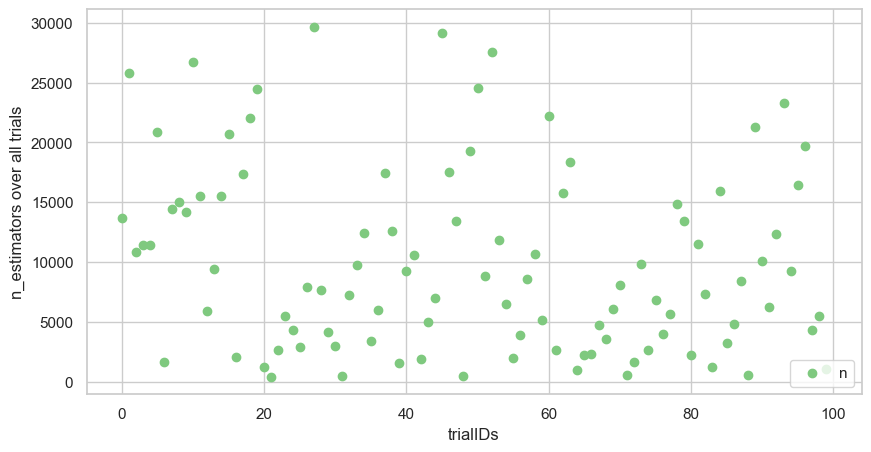

In [23]:
# tested values over all trials

sns.set(style="whitegrid", palette="Accent")

tids = [t['tid'] for t in trials.trials]
n_estimators = [t['misc']['vals']['n_estimators']for t in trials]

fig, ax = plt.subplots()
ax.scatter(tids, n_estimators)

ax.legend(('n_estimators'), loc='lower right')
ax.set_ylabel('n_estimators over all trials')
ax.set_xlabel('trialIDs')
fig.set_size_inches(10, 5)

fig.savefig('./visualizations/tested_values.png')


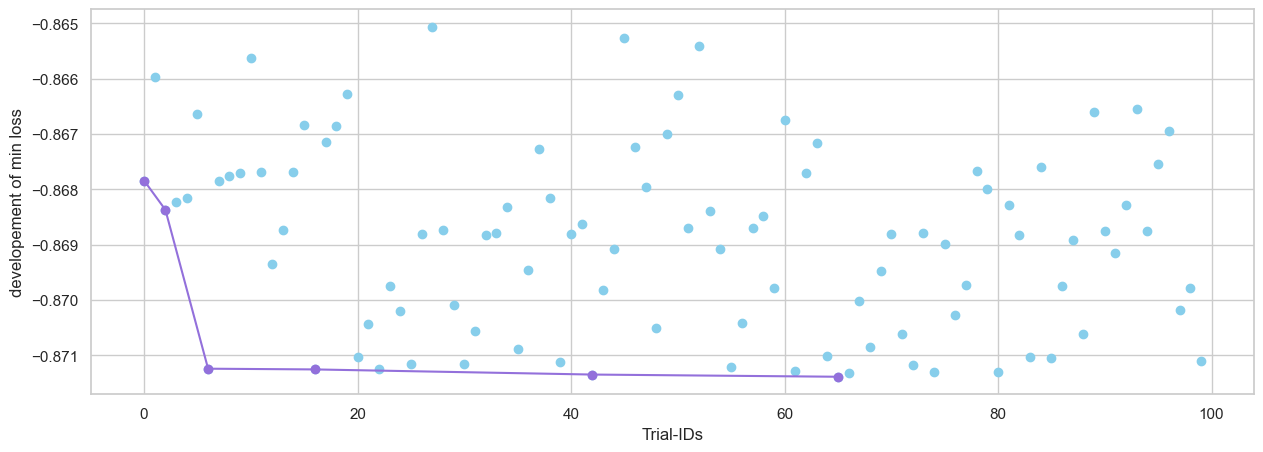

In [26]:
# loss Improvement over Trials
from itertools import chain

# loss Improvement over Trials

def plot_reached_min_losses(trials):
    losses = [t['result']['loss'] for t in trials]
    tids = [t['tid'] for t in trials.trials]
    n_estimators = [t['misc']['vals']['n_estimators'] for t in trials]

    n_estimators = list(chain.from_iterable(n_estimators))

    best_loss = losses[0]
    points_to_plot = []
    points_to_plot.append(losses[0])
    tids_with_loss_improvement = [0]
    counter = 0
    for i in range(1, len(losses)):
        if losses[i] < best_loss:
            tid = tids[i]
            # print(tid)
            points_to_plot.append(losses[i])
            tids_with_loss_improvement.append(tid)
            best_loss = losses[i]

    # plotting with logarithmic y-scale
    sns.set(style="whitegrid")
    fig, ax = plt.subplots()
    # ax.set_yscale('log')
    ax.set_ylabel('developement of min loss')
    ax.set_xlabel('Trial-IDs')
    fig.set_size_inches(15, 5)
    ax.plot(tids_with_loss_improvement, points_to_plot,
            color="mediumpurple", linestyle='-', marker='o')
    ax.scatter(tids, losses, color='skyblue')


plot_reached_min_losses(trials)

fig.savefig('./visualizations/loss_improvement.png')

